In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_absolute_error

round_two_data = pd.read_csv('Round2Day1.csv')
orchids_round_two = round_two_data[round_two_data['product'] == 'ORCHIDS'].copy()
orchids_round_two.set_index('timestamp', inplace=True)

orchids_round_three = pd.read_csv('Round3Data.csv')
orchids_round_three.set_index('timestamp', inplace=True)

orchids_comprehensive = pd.read_csv('orchids.csv', usecols=['timestamp', 'ORCHIDS','TRANSPORT_FEES', 'EXPORT_TARIFF','IMPORT_TARIFF', 'SUNLIGHT','HUMIDITY','DAY'])

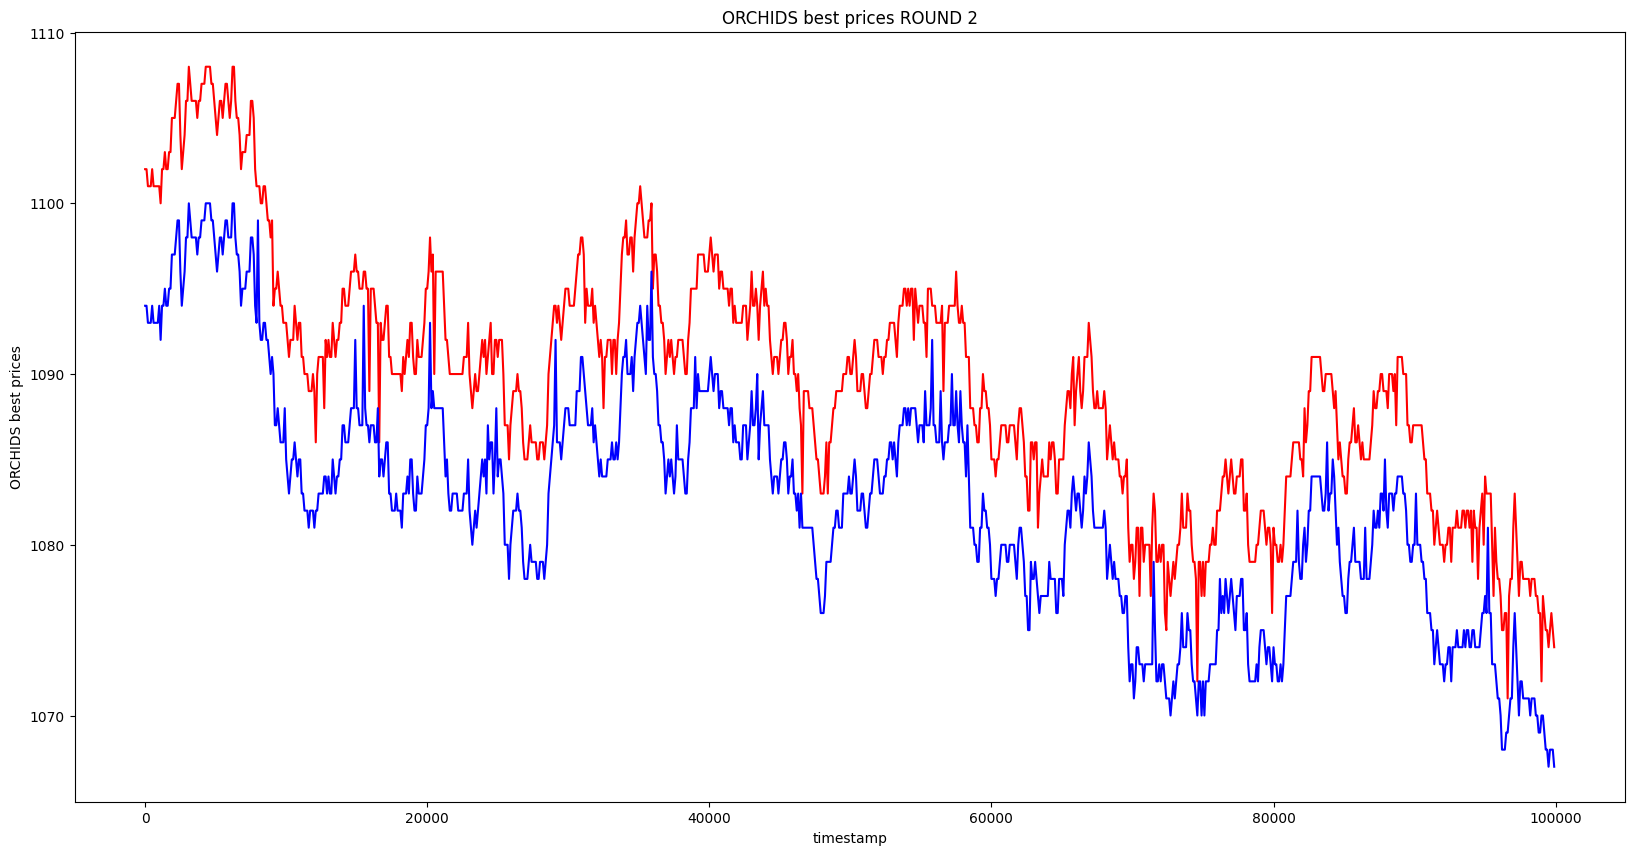

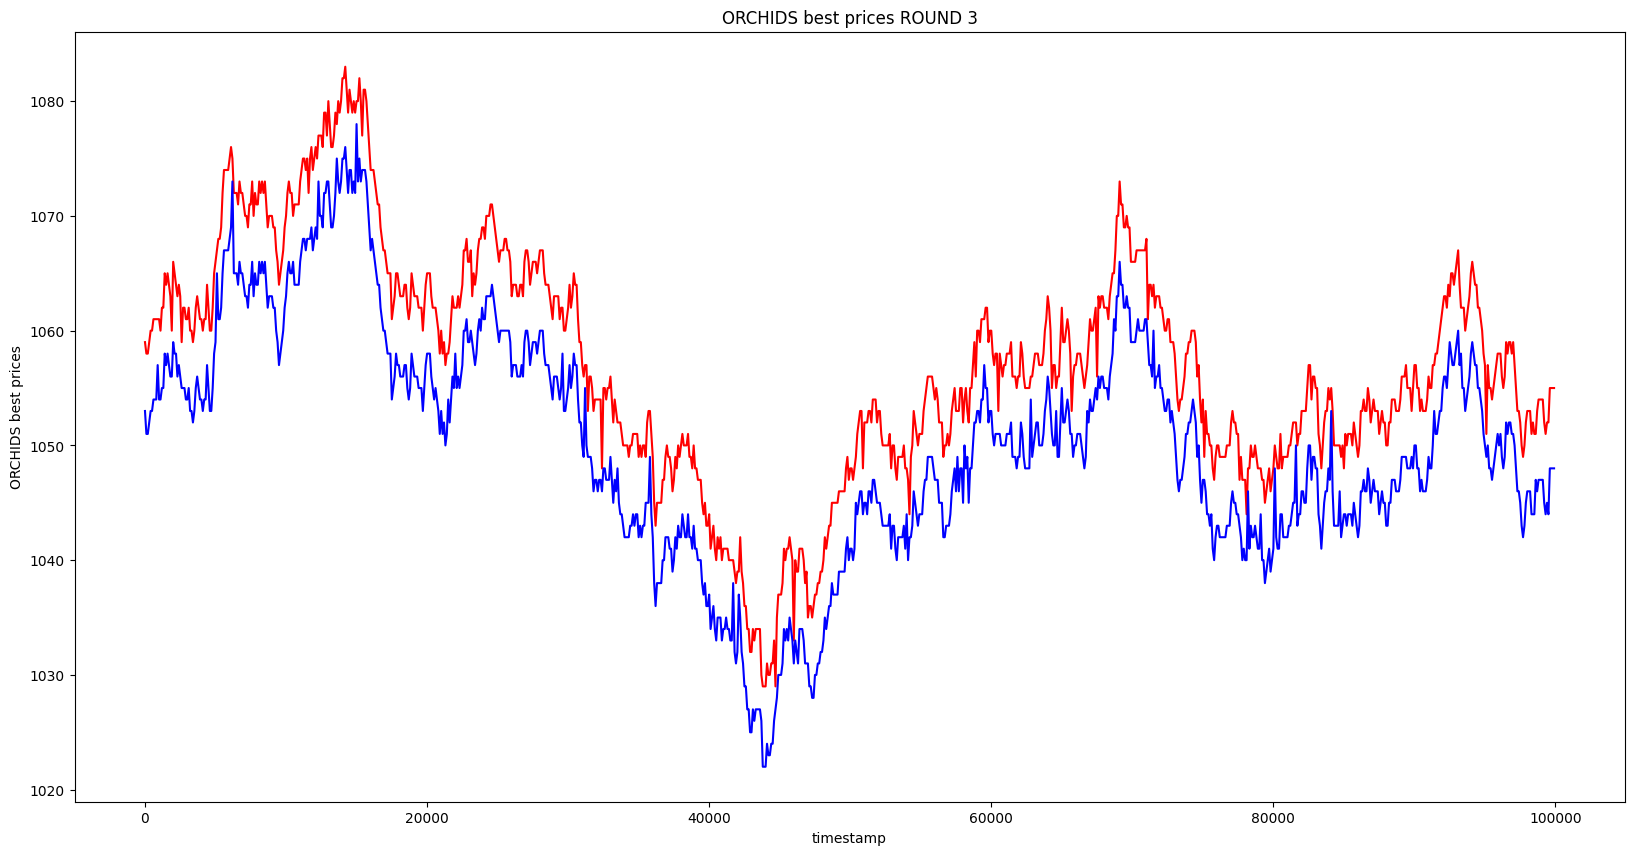

In [28]:
plt.figure(figsize=(20,10))
plt.plot(orchids_round_two.index, orchids_round_two['ask_price_1'], label='ask_price_1', color='red')
plt.plot(orchids_round_two.index, orchids_round_two['bid_price_1'], label='bid_price_1', color='blue')
plt.xlabel('timestamp')
plt.ylabel('ORCHIDS best prices')
plt.title('ORCHIDS best prices ROUND 2')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(orchids_round_three.index, orchids_round_three['ask_price_1'], label='ask_price_1', color='red')
plt.plot(orchids_round_three.index, orchids_round_three['bid_price_1'], label='bid_price_1', color='blue')
plt.xlabel('timestamp')
plt.ylabel('ORCHIDS best prices')
plt.title('ORCHIDS best prices ROUND 3')
plt.show()

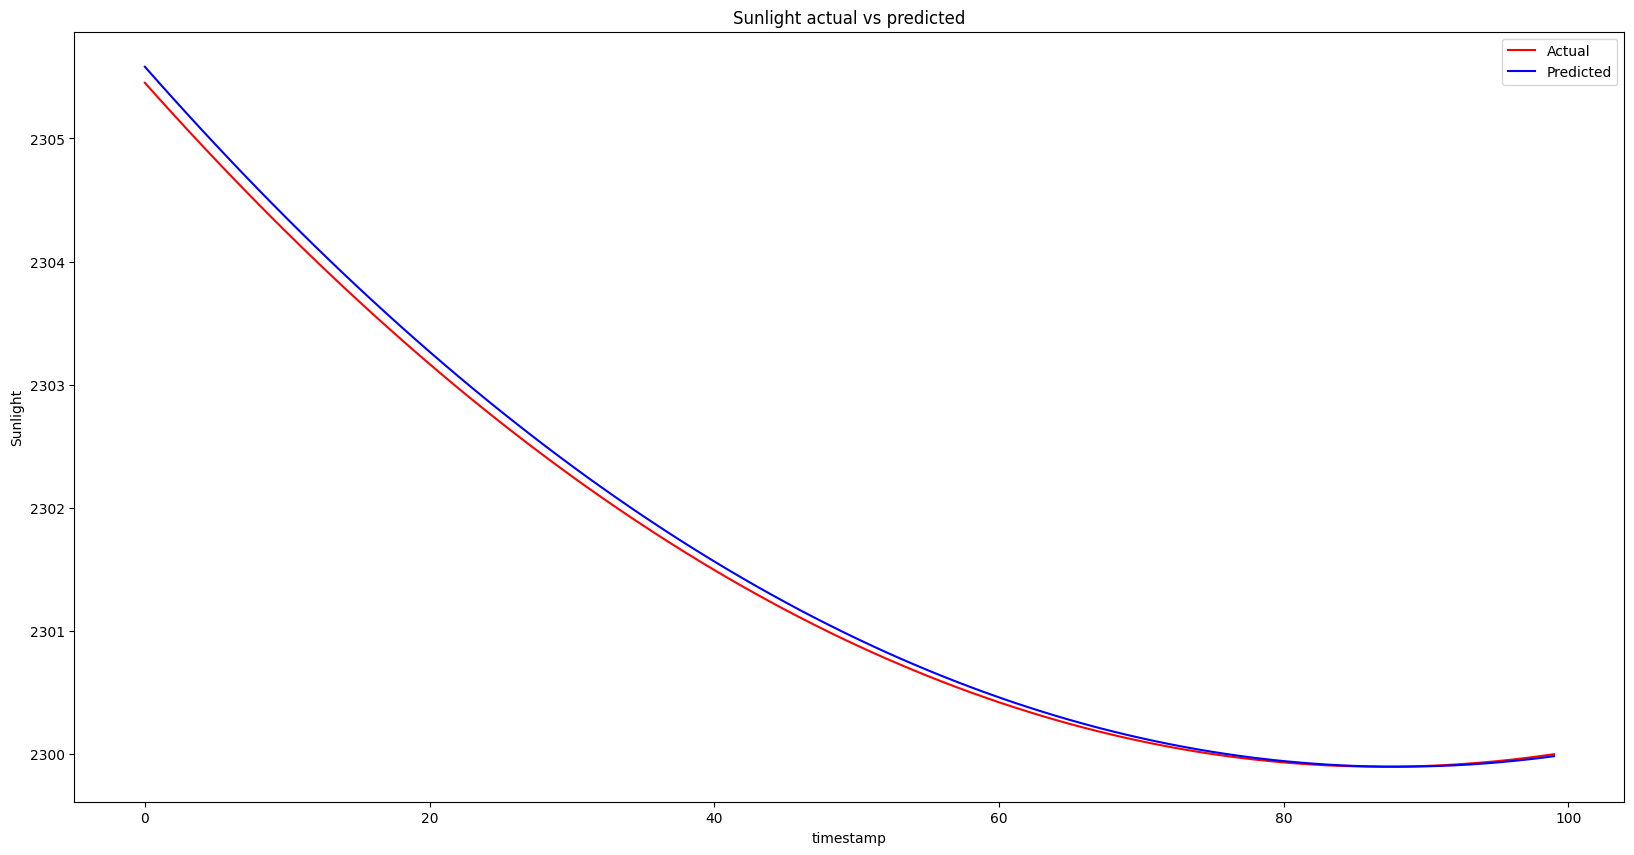

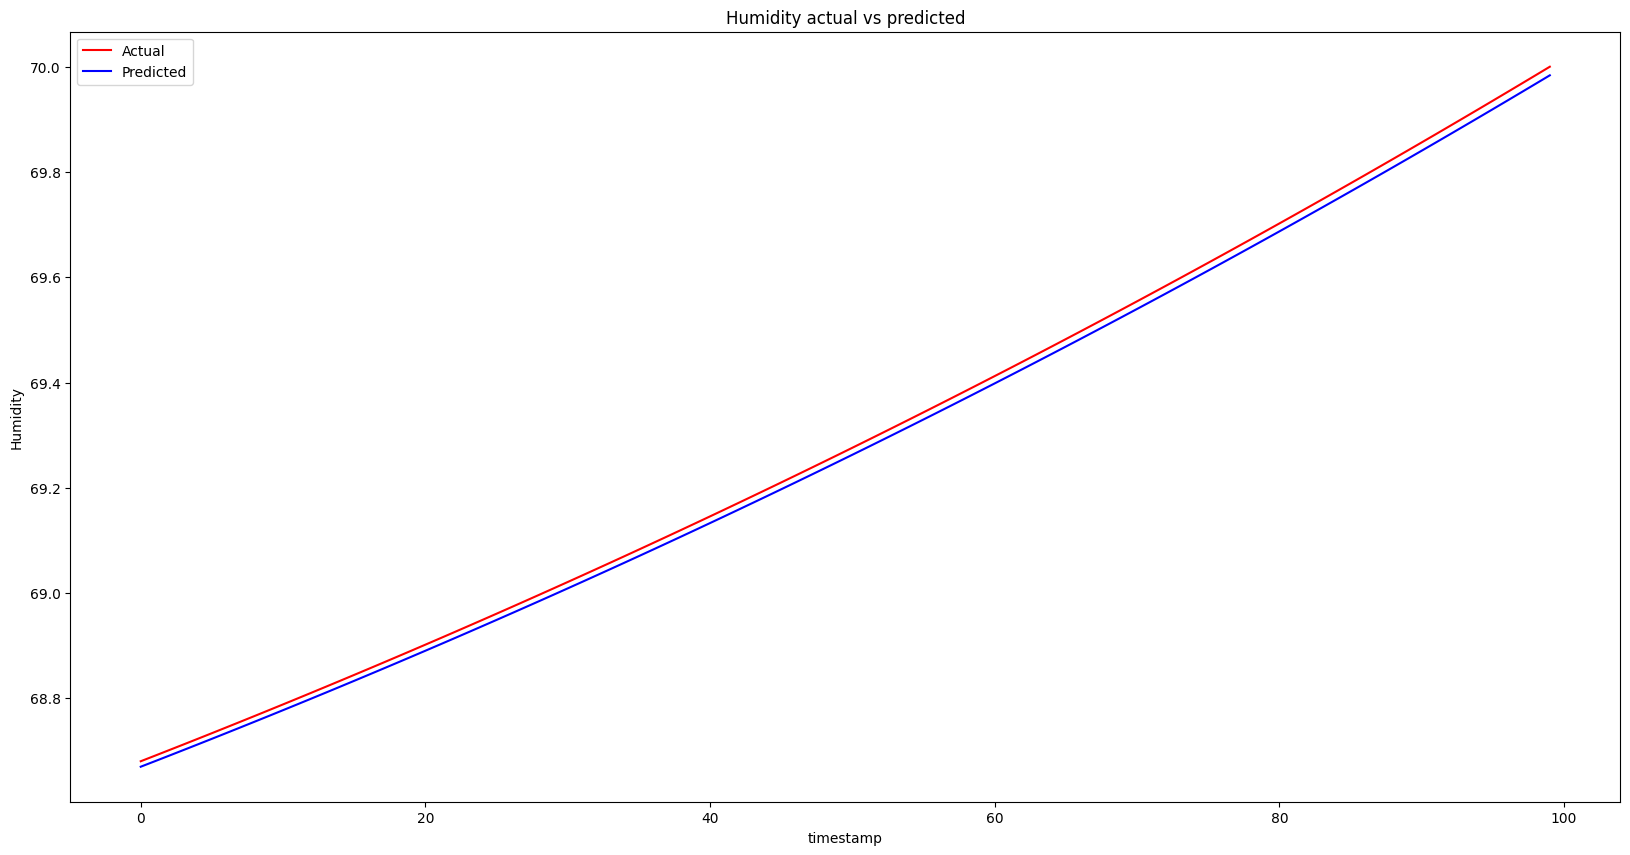

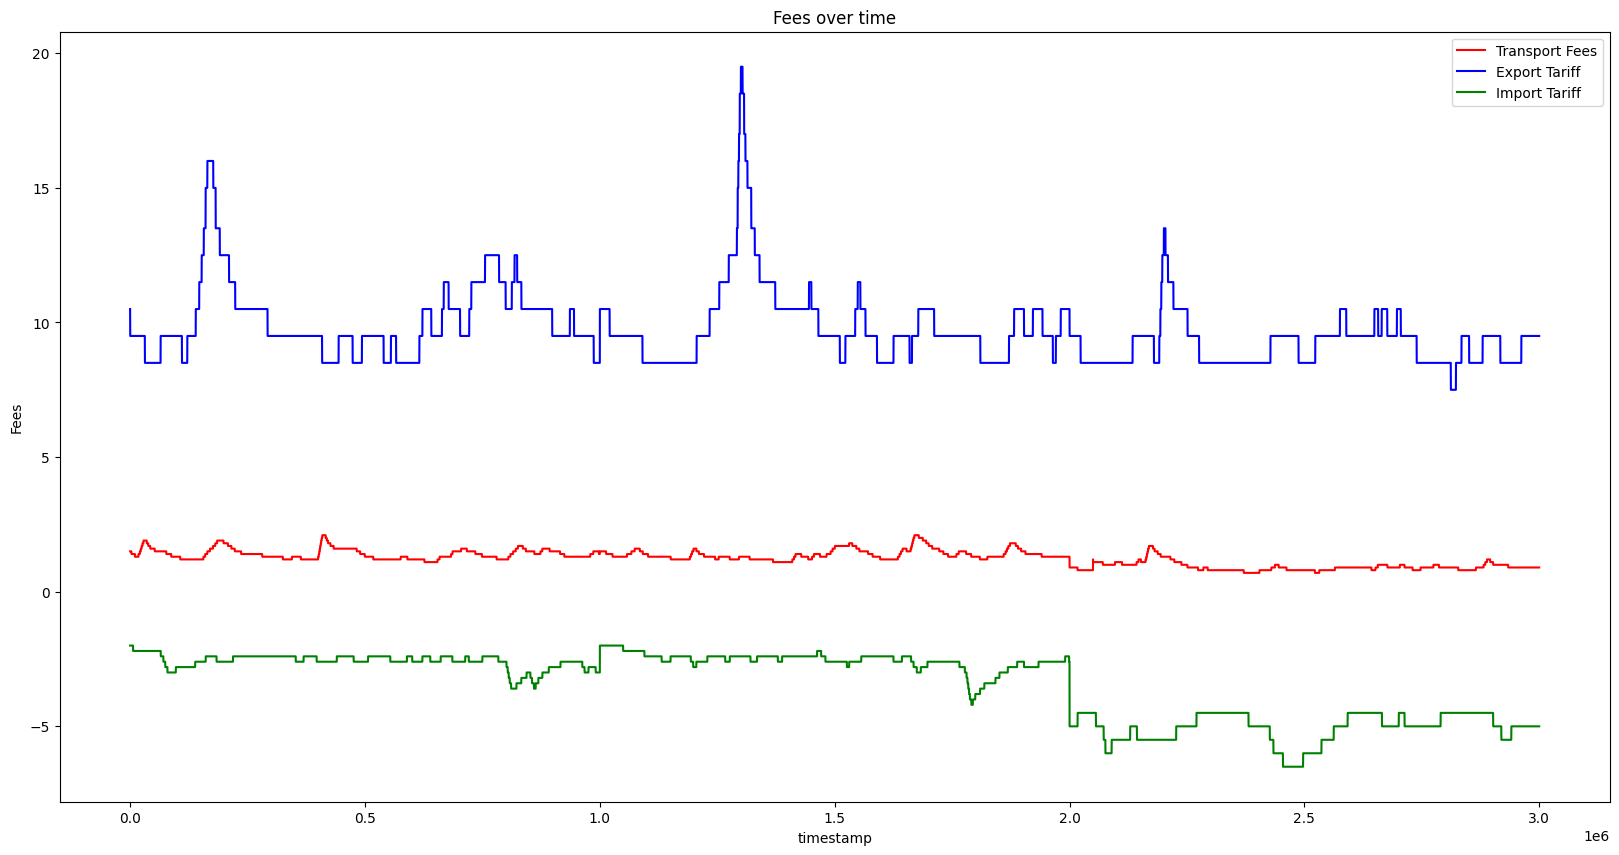

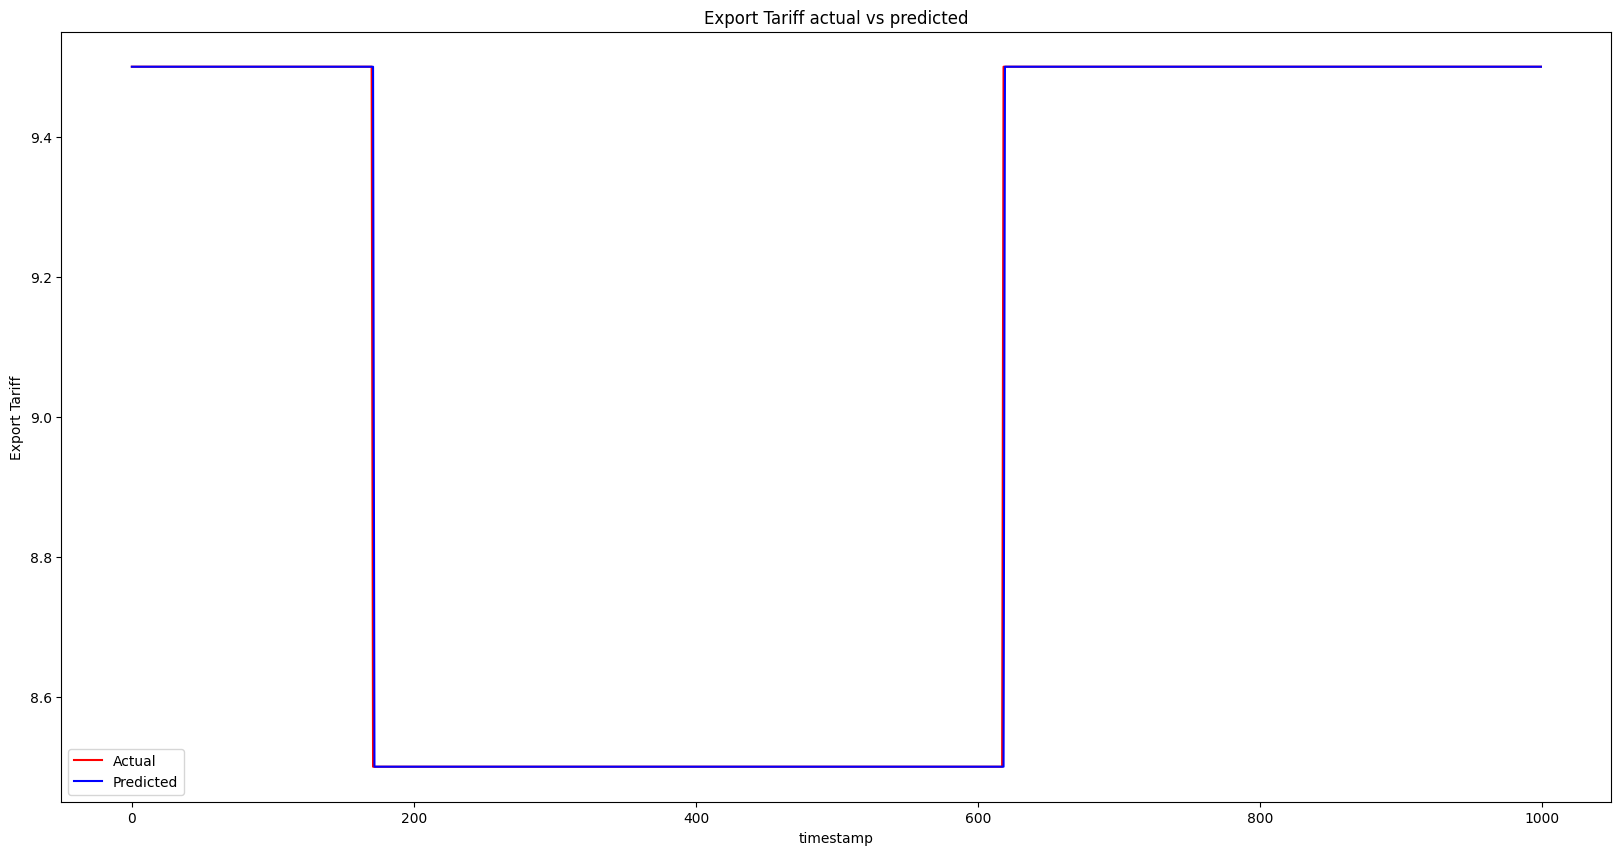

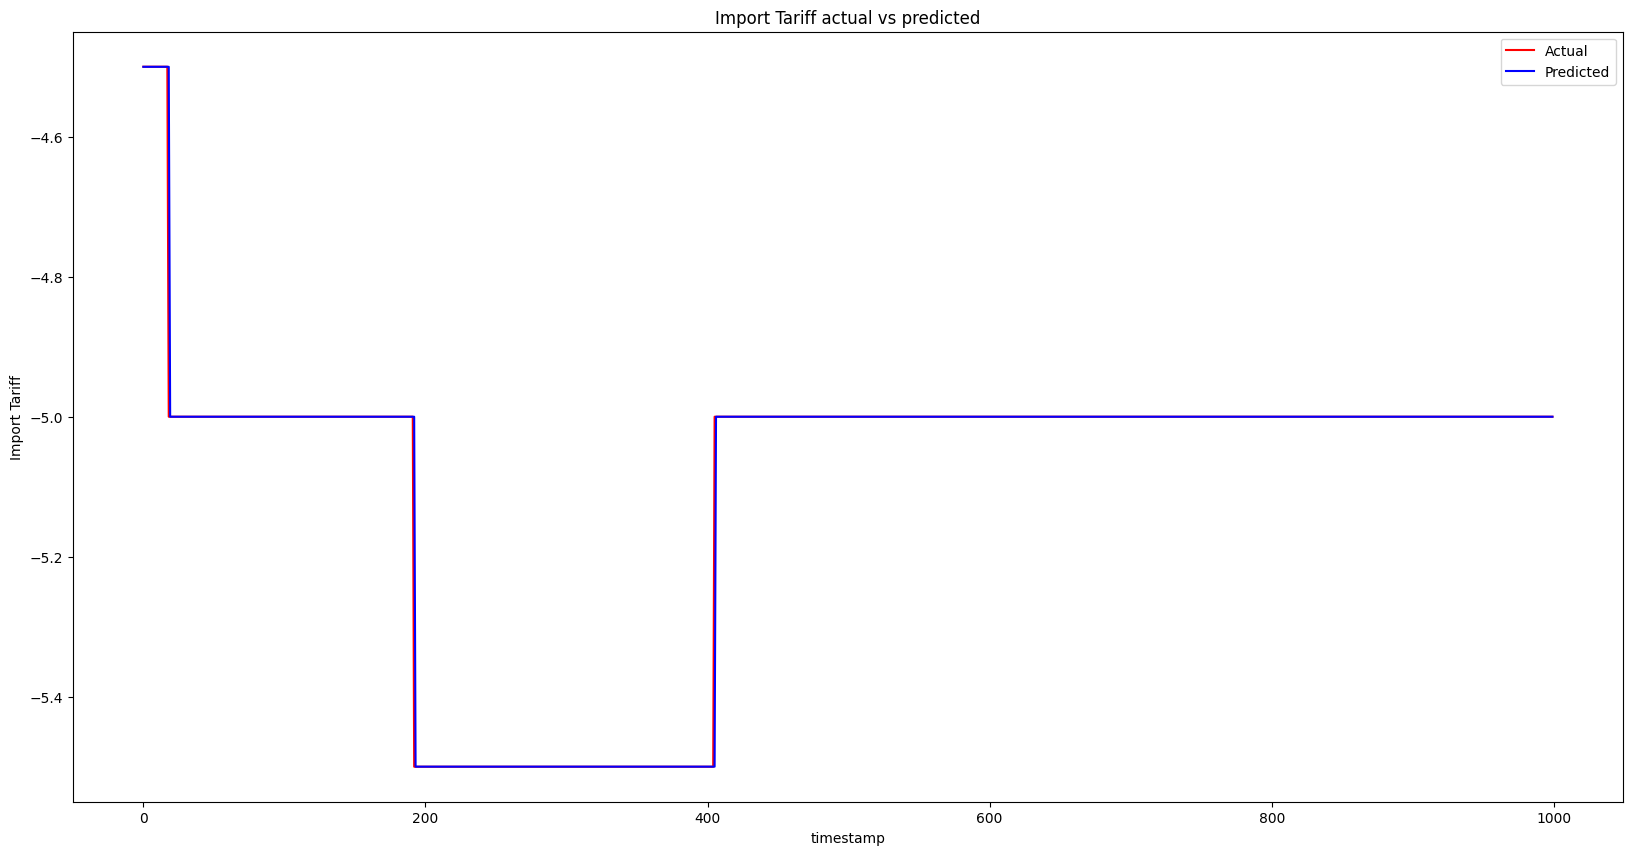

In [29]:
def rolling_linear_regression_with_reg(dataF, target_col: str, lambda_reg=0.01, num_rows=10) -> list[float]:
    data = dataF[target_col]  # Extract data list for the target column

    if len(data) < num_rows:
        return [np.nan] * num_rows

    # Prepare X matrix using ones and the target column data
    X = np.vstack([np.ones(num_rows), data[-num_rows:]]).T
    y = data[-num_rows:]  # Shifted target values for regression

    # Regularization matrix
    reg = lambda_reg * np.eye(X.shape[1])
    # Calculating beta (coefficients) using regularized linear regression
    beta = np.linalg.inv(X.T @ X + reg) @ X.T @ y

    predictions = []
    # Prediction for the next data point
    for j in range(len(data) - num_rows, len(data)):
        next_input = np.array([1, data[j-1]])
        prediction = next_input @ beta
        predictions.append(prediction)

    return predictions

sunlight_predictions = rolling_linear_regression_with_reg(orchids_comprehensive, 'SUNLIGHT', 0.01, 100)
sunlight_actual = orchids_comprehensive['SUNLIGHT'].values[-100:]

plt.figure(figsize=(20,10))
plt.plot(range(100), sunlight_actual, label='Actual', color='red')
plt.plot(range(100), sunlight_predictions, label='Predicted', color='blue')
plt.xlabel('timestamp')
plt.ylabel('Sunlight')
plt.title('Sunlight actual vs predicted')
plt.legend()
plt.show()

humidity_predictions = rolling_linear_regression_with_reg(orchids_comprehensive, 'HUMIDITY', 0.01, 100)
humidity_actual = orchids_comprehensive['HUMIDITY'].values[-100:]

plt.figure(figsize=(20,10))
plt.plot(range(100), humidity_actual, label='Actual', color='red')
plt.plot(range(100), humidity_predictions, label='Predicted', color='blue')
plt.xlabel('timestamp')
plt.ylabel('Humidity')
plt.title('Humidity actual vs predicted')
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(orchids_comprehensive['timestamp'], orchids_comprehensive['TRANSPORT_FEES'], label='Transport Fees', color='red')
plt.plot(orchids_comprehensive['timestamp'], orchids_comprehensive['EXPORT_TARIFF'], label='Export Tariff', color='blue')
plt.plot(orchids_comprehensive['timestamp'], orchids_comprehensive['IMPORT_TARIFF'], label='Import Tariff', color='green')
plt.xlabel('timestamp')
plt.ylabel('Fees')
plt.legend()
plt.title('Fees over time')
plt.show()

export_tariff_predictions = rolling_linear_regression_with_reg(orchids_comprehensive, 'EXPORT_TARIFF', 0.01, 1000)
export_tariff_actual = orchids_comprehensive['EXPORT_TARIFF'].values[-1000:]

plt.figure(figsize=(20,10))
plt.plot(range(1000), export_tariff_actual, label='Actual', color='red')
plt.plot(range(1000), export_tariff_predictions, label='Predicted', color='blue')
plt.xlabel('timestamp')
plt.ylabel('Export Tariff')
plt.title('Export Tariff actual vs predicted')
plt.legend()
plt.show()

import_tariff_predictions = rolling_linear_regression_with_reg(orchids_comprehensive, 'IMPORT_TARIFF', 0.01, 1000)
import_tariff_actual = orchids_comprehensive['IMPORT_TARIFF'].values[-1000:]

plt.figure(figsize=(20,10))
plt.plot(range(1000), import_tariff_actual, label='Actual', color='red')
plt.plot(range(1000), import_tariff_predictions, label='Predicted', color='blue')
plt.xlabel('timestamp')
plt.ylabel('Import Tariff')
plt.title('Import Tariff actual vs predicted')
plt.legend()
plt.show()

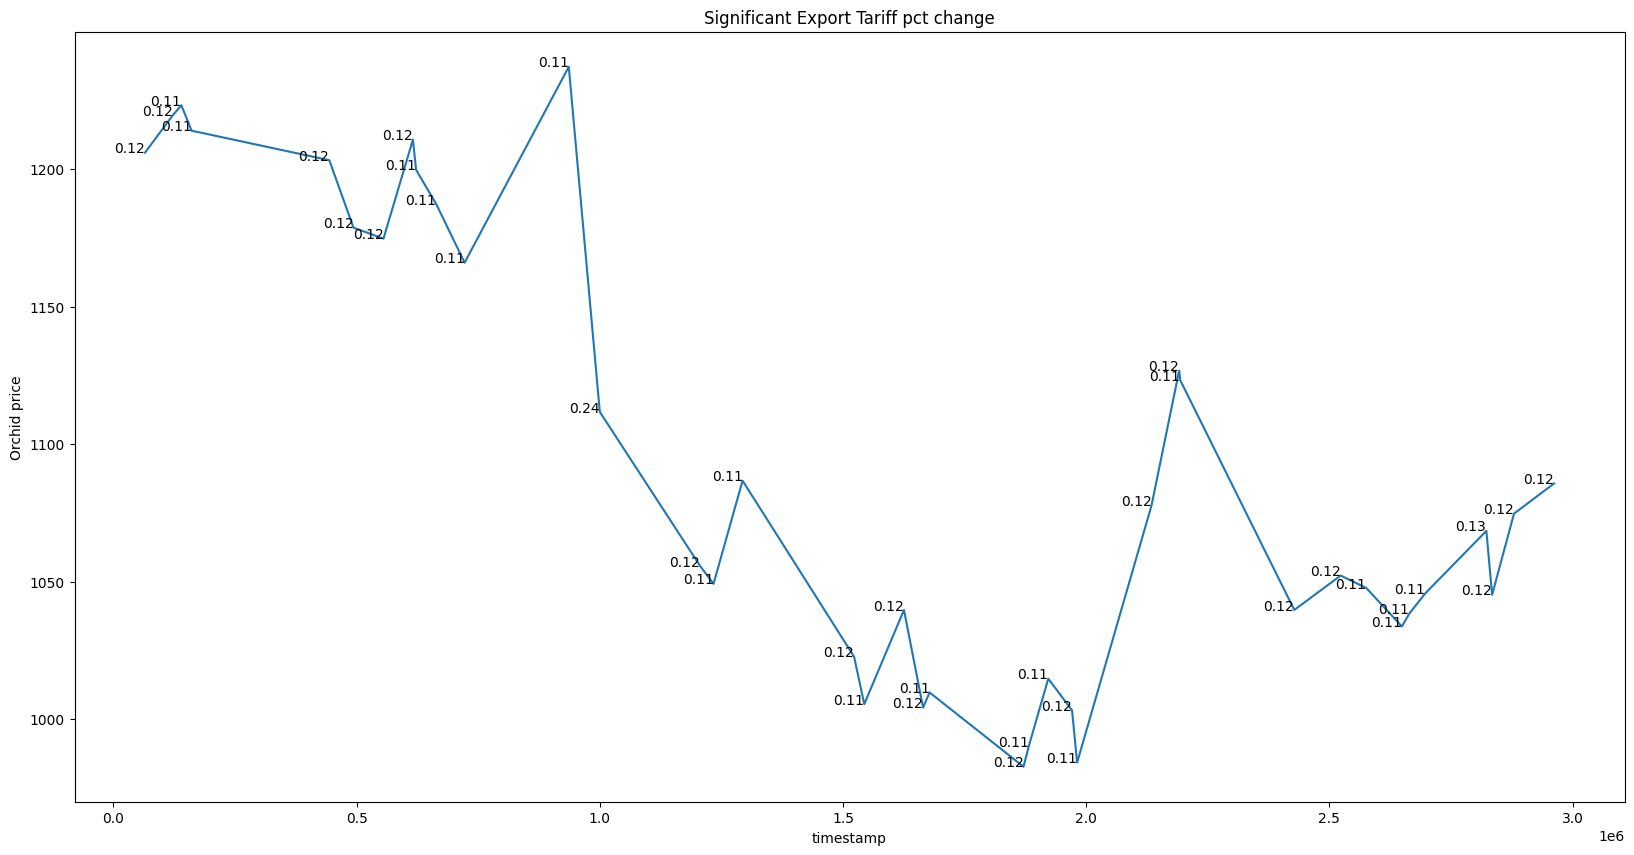

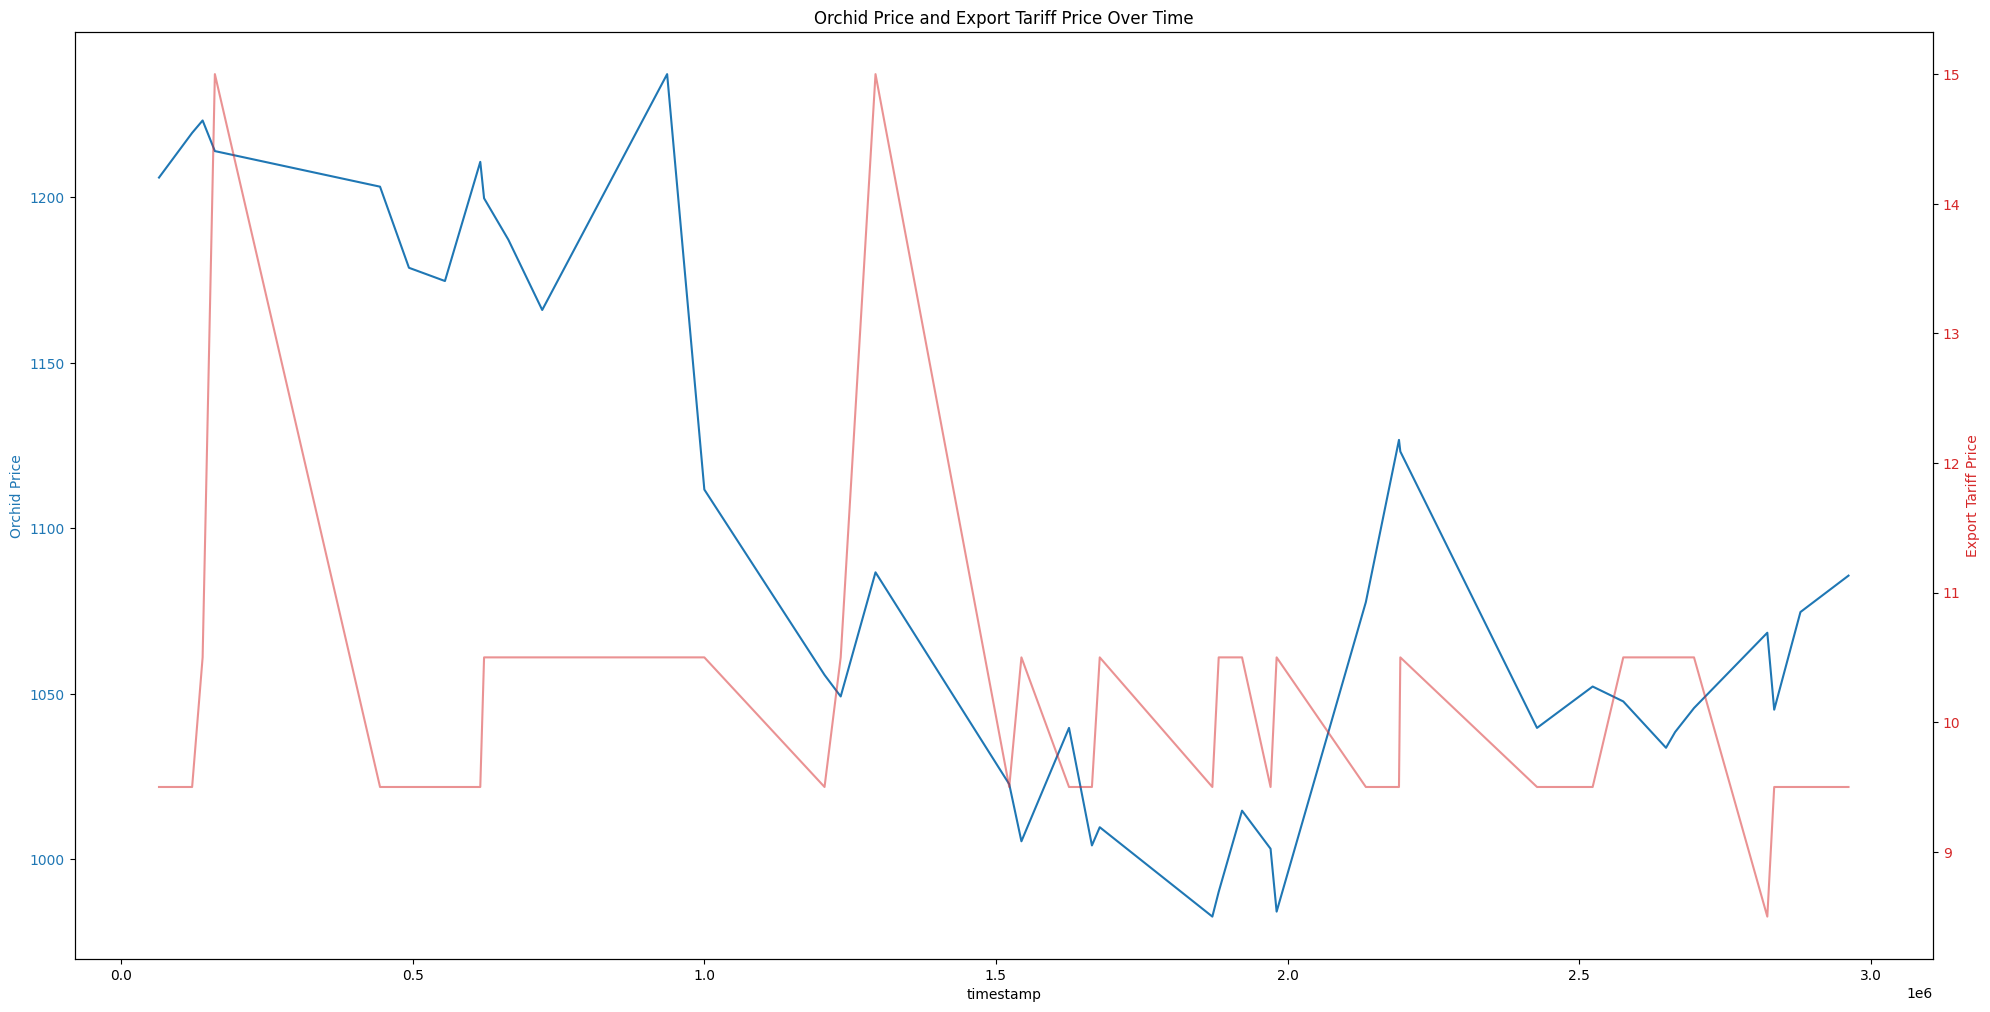

In [30]:
PREDICTION_WINDOW = 1000   # Number of data points to predict, beginning from end of data - PREDICTION_WINDOW

orchids_comprehensive['EXPORT_TARIFF_PCT_CHANGE'] = orchids_comprehensive['EXPORT_TARIFF'].pct_change()
tariff_significant = orchids_comprehensive[orchids_comprehensive['EXPORT_TARIFF_PCT_CHANGE'] > 0.1]

plt.figure(figsize=(20,10))
plt.plot(tariff_significant['timestamp'], tariff_significant['ORCHIDS'])

# Add export tariff percentage change as text annotation for each point
for i in range(len(tariff_significant)):
    plt.text(tariff_significant['timestamp'].iloc[i], tariff_significant['ORCHIDS'].iloc[i], 
             f"{tariff_significant['EXPORT_TARIFF_PCT_CHANGE'].iloc[i]:.2f}", 
             ha='right')

plt.xlabel('timestamp')
plt.ylabel('Orchid price')
plt.title('Significant Export Tariff pct change')
plt.show()

fig, ax1 = plt.subplots(figsize=(20,10))

# Plot orchid price
color = 'tab:blue'
ax1.set_xlabel('timestamp')
ax1.set_ylabel('Orchid Price', color=color)
ax1.plot(tariff_significant['timestamp'], tariff_significant['ORCHIDS'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot export tariff price
color = 'tab:red'
ax2.set_ylabel('Export Tariff Price', color=color)
ax2.plot(tariff_significant['timestamp'], tariff_significant['EXPORT_TARIFF'], color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Orchid Price and Export Tariff Price Over Time')
plt.show()

Mean Absolute Error: 179.89362754043037


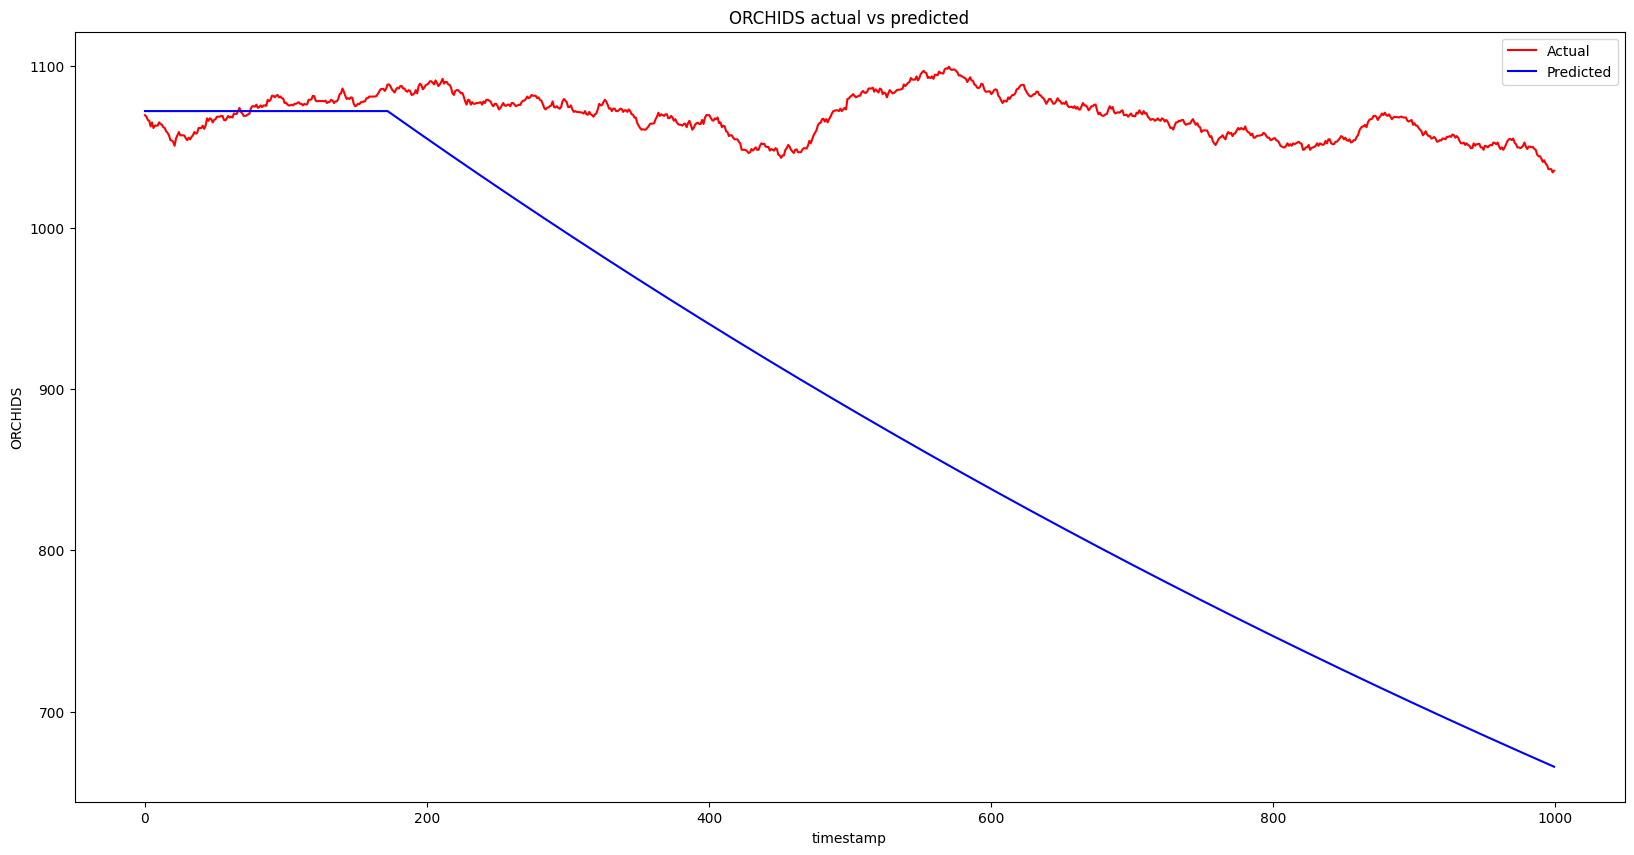

In [31]:
def calc_next_price_observations(sunlight, humidity, export_tariff, mid_price):
    sunlight_hrs_per_day = 10000/24
    sunlight_ten_mins = sunlight_hrs_per_day/6
    sunlight_minus = 0.04/sunlight_ten_mins

    humidity_impact = max(0, (0.04*(abs(humidity-70) - 10)))
    predicted_price = mid_price - humidity_impact

    if sunlight / sunlight_hrs_per_day < 7:
        predicted_price -= (sunlight_minus * mid_price)
    
    if export_tariff > 10:
        predicted_price -= (0.1 * mid_price)
        print(f"Export tariff is {export_tariff}, reducing price by 10%")
    
    return predicted_price

def calc_nth_price_observations(mid_price, n):
    
    sunlights = rolling_linear_regression_with_reg(orchids_comprehensive, 'SUNLIGHT', 0.01, n)
    humidities = rolling_linear_regression_with_reg(orchids_comprehensive, 'HUMIDITY', 0.01, n)
    export_tariffs = rolling_linear_regression_with_reg(orchids_comprehensive, 'EXPORT_TARIFF', 0.01, n)
    
    predictions = []
    for i in range(0 ,len(sunlights)):
        next_price = calc_next_price_observations(sunlights[i], humidities[i], export_tariffs[i], mid_price)
        mid_price = next_price
        predictions.append(next_price)
    
    return predictions

predictions = calc_nth_price_observations(orchids_comprehensive['ORCHIDS'].values[-PREDICTION_WINDOW - 1], PREDICTION_WINDOW)
orchids_actual = orchids_comprehensive['ORCHIDS'].values[-PREDICTION_WINDOW:]
mae = mean_absolute_error(orchids_actual, predictions)
print(f"Mean Absolute Error: {mae}")

plt.figure(figsize=(20,10))
plt.plot(range(PREDICTION_WINDOW), orchids_actual, label='Actual', color='red')
plt.plot(range(PREDICTION_WINDOW), predictions, label='Predicted', color='blue')
plt.xlabel('timestamp')
plt.ylabel('ORCHIDS')
plt.legend()
plt.title('ORCHIDS actual vs predicted')
plt.show()
